In [47]:
import pandas as pd
import numpy as np
import pyross
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv('data-by-day.csv', parse_dates = ['date_of_interest'])

In [49]:
df['daily_death_rate'] = df['DEATH_COUNT']/df['CASE_COUNT']
df['cum_case'] = df['CASE_COUNT'].cumsum()
df['cum_death'] = df['DEATH_COUNT'].cumsum()
df['death_rate'] = df['cum_death']/df['cum_case']
df['growth_rate'] = df['CASE_COUNT'].div(df['cum_case'].shift(1))
gamma = 1/7
df['Rt'] = (df['growth_rate']/gamma)+1
df['ratio'] = df['cum_case'].div(df['cum_case'].shift(1))

In [50]:
lockdown_buffer=14
vaccination_buffer=30
idxs=[17,17+lockdown_buffer,246,350+vaccination_buffer]

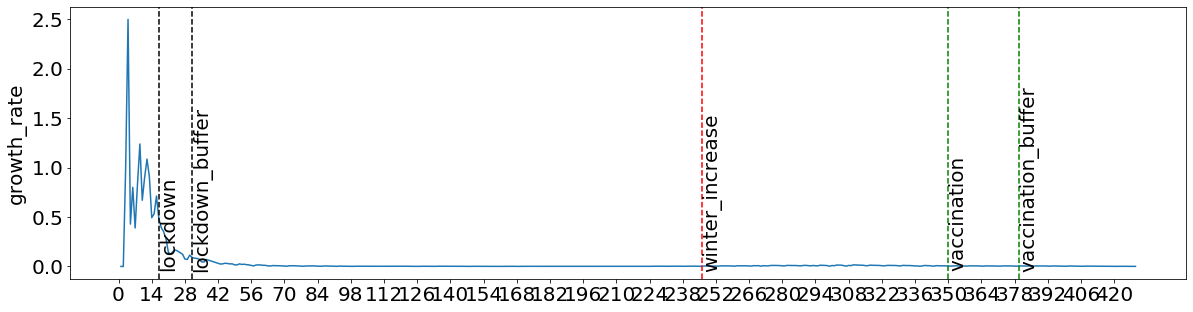

In [51]:
# growth_rate
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(df['growth_rate'])
plt.ylabel('growth_rate')
plt.xticks(np.arange(0, 430, 14.0))
plt.axvline(x=idxs[0],color='k', linestyle='--')
plt.text(idxs[0],0,'lockdown',rotation=90)
plt.axvline(x=idxs[1],color='k', linestyle='--')
plt.text(idxs[1],0,'lockdown_buffer',rotation=90)
plt.axvline(x=idxs[2],color='r', linestyle='--')
plt.text(idxs[2],0,'winter_increase',rotation=90)
plt.axvline(x=350,color='g', linestyle='--')
plt.text(350,0,'vaccination',rotation=90)
plt.axvline(x=idxs[3],color='g', linestyle='--')
plt.text(idxs[3],0,'vaccination_buffer',rotation=90)
#plt.rc('font',size=20)
plt.show()

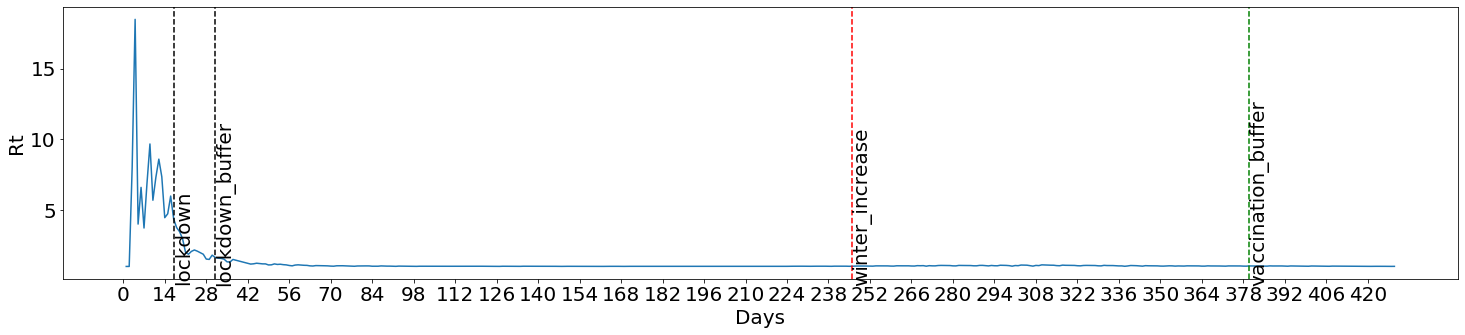

In [61]:
# Rt
plt.rcParams["figure.figsize"] = (25,5)
plt.plot(df['Rt'])
plt.ylabel('Rt')
plt.xticks(np.arange(0, 430, 14.0))
plt.axvline(x=idxs[0],color='k', linestyle='--')
plt.text(idxs[0],0,'lockdown',rotation=90)
plt.axvline(x=idxs[1],color='k', linestyle='--')
plt.text(idxs[1],0,'lockdown_buffer',rotation=90)
plt.axvline(x=idxs[2],color='r', linestyle='--')
plt.text(idxs[2],0,'winter_increase',rotation=90)
#plt.axvline(x=350,color='g', linestyle='--')
#plt.text(350,0,'vaccination',rotation=90)
plt.axvline(x=idxs[3],color='g', linestyle='--')
plt.text(idxs[3],0,'vaccination_buffer',rotation=90)
plt.xlabel('Days')
plt.show()

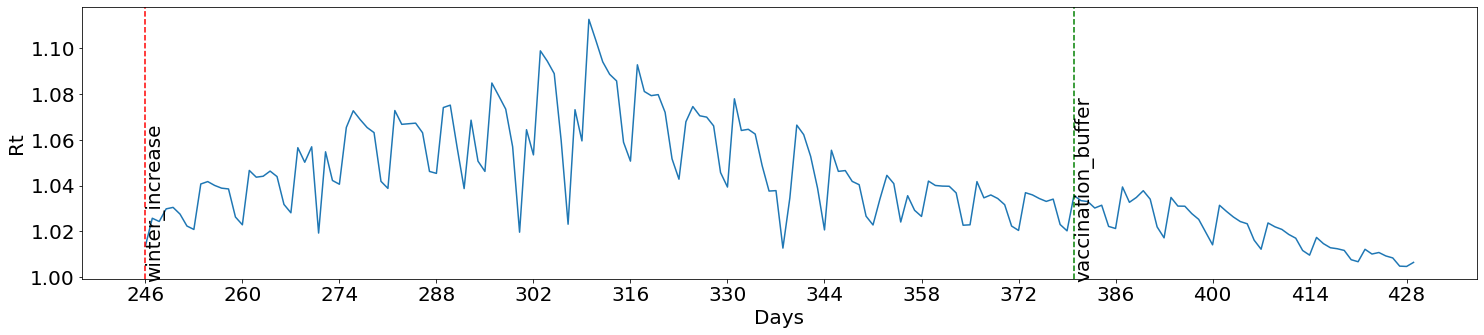

In [62]:
plt.rcParams["figure.figsize"] = (25,5)
plt.plot(df.loc[idxs[2]:,'Rt'])
plt.ylabel('Rt')
plt.xticks(np.arange(idxs[2], 430, 14.0))
plt.axvline(x=idxs[2],color='r', linestyle='--')
plt.text(idxs[2],1,'winter_increase',rotation=90)
#plt.axvline(x=350,color='g', linestyle='--')
#plt.text(350,0,'vaccination',rotation=90)
plt.axvline(x=idxs[3],color='g', linestyle='--')
plt.text(idxs[3],1,'vaccination_buffer',rotation=90)
plt.xlabel('Days')
plt.show()

### Simulation

In [35]:
def get_SEIR(idx0,idx1,S0,E0,I0,s0=1,gamma=1/7,d=0.006,k=1/2):
    r0 = df.loc[idx0:idx1,'Rt'].mean()
    beta = r0*((gamma+d)/s0)*((k+d)/k)
    print('inferred beta from real data is:', round(beta,4))
    
    M = 1                  # the SIR model has no age structure
    Ni =  18804000*np.ones(M)   # so there is only one age group 
    N = np.sum(Ni)         # and the total population is the size of this age group

    alpha = 0            # fraction of asymptomatic infectives 
    gIa   = gamma+d           # removal rate of asymptomatic infectives 
    gIs   = gamma+d            # removal rate of symptomatic infectives 
    gE    = k+d          # removal rate of E
    fsa   = 1              # Fraction by which symptomatic individuals do not self isolate

    E0  = np.array([E0])
    Ia0 = np.array([0])     # the SIR model has only one kind of infective 
    Is0 = np.array([I0])     # we take these to be symptomatic 
    S0  = np.array([S0])    # so that the initial susceptibles are obtained from S + Ia + Is + R = N
    R0  = N-E0-Ia0-Is0-S0     # and assume there are no removed individuals initially 
    
    # duration of simulation and data file
    Tf = 430;  Nt=430;  
    
    def contactMatrix(t):   
        return np.identity(M) 
    
    # instantiate model
    parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
    model = pyross.deterministic.SEIR(parameters, M, Ni)
    
    # simulate model
    data=model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nt)
    
    S_  = list(data['X'][:,0].flatten()[idx0:idx1])
    E_  = list(data['X'][:,1].flatten()[idx0:idx1])
    I_ = list(data['X'][:,3].flatten()[idx0:idx1])
    return S_,E_,I_


In [36]:
finali=[]
finalr=[]
lockdown_buffer=30
vaccination_buffer=30
date=[17,17+lockdown_buffer,246,350+vaccination_buffer]
c = [[],[17],[17,17+lockdown_buffer,246,350+vaccination_buffer]]

In [37]:
for idx in c:
    idxs=[0]+idx+[430]
    S=[]
    E=[]
    I=[]
    pop = 18804000
    E0 = 0
    I0 = 1
    S0 = pop-1
    for i in range(len(idxs)-1):
        idx0 = idxs[i]
        idx1 = idxs[i+1]
        s,e,i = get_SEIR(idx0,idx1,S0,E0,I0)
        S+=s
        E+=e
        I+=i
        S0 = S[-1]
        E0 = E[-1]
        I0 = I[-1]
    S=np.array(S)
    E=np.array(E)
    I=np.array(I)
    R=pop-S-E-I

    finali.append(I)
    finalr.append(R)
    print('\n')

inferred beta from real data is: 0.1945


inferred beta from real data is: 0.9558
inferred beta from real data is: 0.1643


inferred beta from real data is: 0.9558
inferred beta from real data is: 0.2745
inferred beta from real data is: 0.1541
inferred beta from real data is: 0.1581
inferred beta from real data is: 0.1538




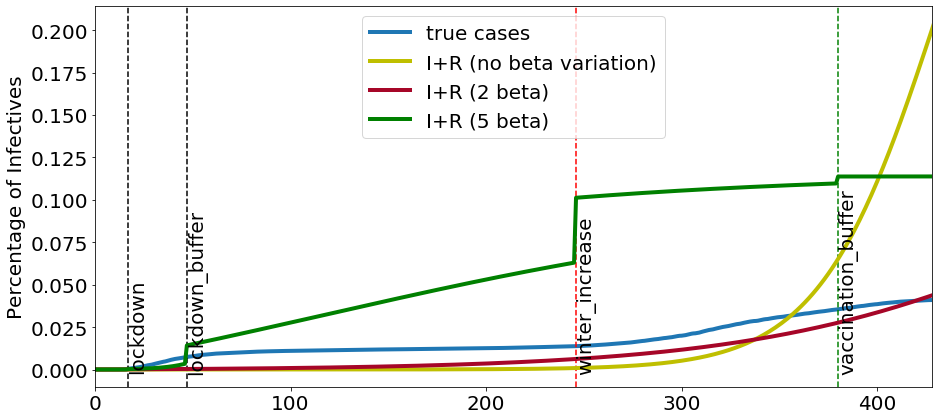

In [67]:
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(df['cum_case']/pop, lw=4,label = 'true cases')
plt.ylabel('Percentage of Infectives')
plt.xticks(np.arange(0, 428, 100))
plt.axvline(x=date[0],color='k', linestyle='--')
plt.text(date[0],0,'lockdown',rotation=90)
plt.axvline(x=date[1],color='k', linestyle='--')
plt.text(date[1],0,'lockdown_buffer',rotation=90)
plt.axvline(x=date[2],color='r', linestyle='--')
plt.text(date[2],0,'winter_increase',rotation=90)
#plt.axvline(x=350,color='g', linestyle='--')
#plt.text(350,0,'vaccination',rotation=90)
plt.axvline(x=date[3],color='g', linestyle='--')
plt.text(date[3],0,'vaccination_buffer',rotation=90)

plt.plot((finali[0]+finalr[0])/pop, '-', color='y', label='I+R (no beta variation)', lw=4) #no variation in beta
plt.plot((finali[1]+finalr[1])/pop, '-', color='#A60628', label='I+R (2 beta)', lw=4) # 2 beta
plt.plot((finali[2]+finalr[2])/pop, '-', color='g', label='I+R (5 beta)', lw=4) # 5 beta

#plt.ylim([0, 0.4])
plt.xlim([0, 428])
plt.legend(loc='upper center')
plt.show()